In [1]:
import os
%load_ext autoreload
%autoreload 2


In [2]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split


# repeating the data prep from the previous notebook
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# EDIT: splitting training data into train and val because this is better practice than using test data to
# choose models/hyperparameters
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

x_train = x_train.astype(numpy.float32)
# EDIT: adding pre-processing to validation data 
x_val  = x_val.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_val  /= 255.
x_test  /= 255.

print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
x_val = x_val.reshape(x_val.shape[0], numpy.prod(x_val[0,:,:].shape))
x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))

print(x_train.shape)
y_train = y_train.astype(numpy.int32)
y_val  = y_val.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'val:',len(x_val), 'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)

# one-hot encoding:
nb_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, nb_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

11490434/11490434 [==============================] - 0s 0us/step
(40200, 28, 28)
(40200, 784)

MNIST data loaded: train: 40200 val: 19800 test: 10000
X_train: (40200, 784)
y_train: (40200,)


In [8]:
# Here we import an implementation of a two-layer neural network 
# this code is based on pieces of the first assignment from Stanford's CSE231n course, 
# hosted at https://github.com/cs231n/cs231n.github.io with the MIT license
from fc_net import TwoLayerNet

In [9]:
# a simple implementation of stochastic gradient descent
def sgd(model, gradients, learning_rate):
    for p, w in model.params.items():
        dw = gradients[p]
        new_weights = w - learning_rate * dw
        model.params[p] = new_weights

In [11]:
# one training step
def learn(model, x_train, y_train_onehot, learning_rate):
    loss, gradients = model.loss(x_train, y_train_onehot)
    sgd(model, gradients, learning_rate)
    return loss

def accuracy(model, x, true_values):
    scores = model.loss(x)
    predictions = numpy.argmax(scores, axis=1)
    N = predictions.shape[0]
    # EDIT: squeezing true_values from 2d to 1d speeds up this function
    true_values_1d = numpy.squeeze(true_values)
    acc = (true_values_1d == predictions).sum() / N
    return acc
    

In [12]:
# EDIT: decided to track how long each epoch takes
import time

In [13]:
# EDIT: also track validation data
# EDIT: factoring this out into a function to make it easier to compare options
def training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot):
    num_features = x_train.shape[1] # this is the number of pixels
    nb_classes = y_train_onehot.shape[1]
    
    # The weights are initialized from a normal distribution with standard deviation weight_scale
    model = TwoLayerNet(input_dim=num_features, hidden_dim=hidden_dim, num_classes=nb_classes, weight_scale=weight_scale)
    
    num_examples_train = x_train.shape[0]
    num_batches_train = int(num_examples_train / batch_size)
    
    losses = numpy.zeros((num_batches_train*num_epochs,2)) # 1st column for training data, 2nd for validation data
    # EDIT: also track accuracy
    accuracies = numpy.zeros((num_batches_train*num_epochs,2)) 
    
    indices_train = numpy.arange(num_examples_train)
    num_examples_val = x_val.shape[0]
    indices_val = numpy.arange(num_examples_val)

    i = 0
    for epoch in range(0, num_epochs):
        start_epoch = time.time()
        # in each epoch, we loop over all of the training examples
        for step in range(0, num_batches_train):
            # grabbing the next training batch
            offset_train = step * batch_size
            batch_range_train = range(offset_train, offset_train+batch_size)
            x_train_batch = x_train[batch_range_train, :]
            # EDIT: keep around non-onehot labels as well for accuracy calculation
            y_train_onehot_batch = y_train_onehot[batch_range_train,:]
            y_train_batch = y_train[batch_range_train,numpy.newaxis]

            # one approach: grab a random validation batch (random offset into number of validation examples)
            offset_val = numpy.random.randint(low=0, high=num_examples_val-batch_size)
            batch_range_val = range(offset_val, offset_val+batch_size)
            x_val_batch = x_val[batch_range_val, :]
            y_val_onehot_batch = y_val_onehot[batch_range_val,:]
            y_val_batch = y_val[batch_range_val,numpy.newaxis]

            # feed the next batch in to do one sgd step
            loss_train = learn(model, x_train_batch, y_train_onehot_batch, learning_rate)

            # check training & validation loss & accuracy
            losses[i,0] = loss_train
            
            # could save time by commenting out the next three lines and only tracking at the epoch level
            accuracies[i,0] = accuracy(model, x_train_batch, y_train_batch)
            losses[i,1], _ = model.loss(x_val_batch, y_val_onehot_batch)
            accuracies[i,1] = accuracy(model, x_val_batch, y_val_batch)
            i += 1

        # slower, so we're only doing this once per epoch: checking accuracy on all of the data at once
        acc_train = accuracy(model, x_train, y_train)
        acc_val = accuracy(model, x_val, y_val)
        
        # reshuffle the data so that we get a new set of batches
        numpy.random.shuffle(indices_train)
        x_train = x_train[indices_train,:]
        y_train = y_train[indices_train] # keep this shuffled the same way for use in accuracy calculation
        y_train_onehot = y_train_onehot[indices_train,:]

        numpy.random.shuffle(indices_val)
        x_val = x_val[indices_val,:]
        y_val = y_val[indices_val] 
        y_val_onehot = y_val_onehot[indices_val,:]
        end_epoch = time.time()
        time_this_epoch = end_epoch - start_epoch
        print("epoch %d took %.1f seconds, training loss %.5f (last batch), training accuracy %.3f, validation accuracy %.3f" % (epoch, time_this_epoch, loss_train, acc_train, acc_val))
    return losses, accuracies, model

    

epoch 0 took 28.4 seconds, training loss 2.30211 (last batch), training accuracy 0.116, validation accuracy 0.117
epoch 1 took 27.7 seconds, training loss 2.30079 (last batch), training accuracy 0.136, validation accuracy 0.137
epoch 2 took 27.5 seconds, training loss 2.29965 (last batch), training accuracy 0.159, validation accuracy 0.159
epoch 3 took 27.5 seconds, training loss 2.29871 (last batch), training accuracy 0.183, validation accuracy 0.182
epoch 4 took 24.5 seconds, training loss 2.29759 (last batch), training accuracy 0.210, validation accuracy 0.209
epoch 5 took 26.0 seconds, training loss 2.29637 (last batch), training accuracy 0.238, validation accuracy 0.238
epoch 6 took 24.9 seconds, training loss 2.29542 (last batch), training accuracy 0.265, validation accuracy 0.265
epoch 7 took 24.5 seconds, training loss 2.29443 (last batch), training accuracy 0.292, validation accuracy 0.290
epoch 8 took 27.8 seconds, training loss 2.29330 (last batch), training accuracy 0.316, 

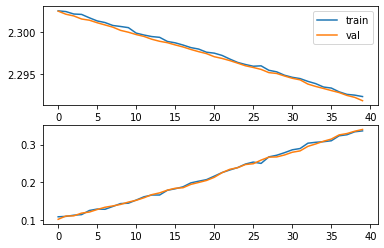

In [14]:
# these are the hyperparameters we had in class
learning_rate = 0.01  
batch_size = 10000
num_epochs = 10
hidden_dim = 300
weight_scale = .01
losses, accuracies, model = training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot)

# EDIT: plot training & val, loss & accuracy
plt.figure()
plt.subplot(2,1,1)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies[:,0])
plt.plot(accuracies[:,1])

Homework: improve the accuracy of this model.
Update this notebook so that the accuracy is improved. How high can you get it? You could change things directly in the notebook, such as increasing the number of epochs, changing the learning weight, changing the width of the hidden layer, etc. If you're more ambitious, you could also try changing the model definition itself by checking out the associated Python files. For example, you could add more layers to the network. The current notebook has a training accuracy of about 43%, but will vary with randomness.

0.03210479558034334
epoch 0 took 38.6 seconds, training loss 0.69537 (last batch), training accuracy 0.844, validation accuracy 0.845
epoch 1 took 38.6 seconds, training loss 0.51834 (last batch), training accuracy 0.877, validation accuracy 0.875
epoch 2 took 44.4 seconds, training loss 0.40532 (last batch), training accuracy 0.888, validation accuracy 0.888
epoch 3 took 35.4 seconds, training loss 0.38859 (last batch), training accuracy 0.896, validation accuracy 0.897
epoch 4 took 35.9 seconds, training loss 0.38082 (last batch), training accuracy 0.903, validation accuracy 0.904
epoch 5 took 37.5 seconds, training loss 0.34102 (last batch), training accuracy 0.906, validation accuracy 0.909
epoch 6 took 38.0 seconds, training loss 0.31474 (last batch), training accuracy 0.909, validation accuracy 0.911
epoch 7 took 34.4 seconds, training loss 0.33378 (last batch), training accuracy 0.913, validation accuracy 0.915
epoch 8 took 34.2 seconds, training loss 0.30850 (last batch), train

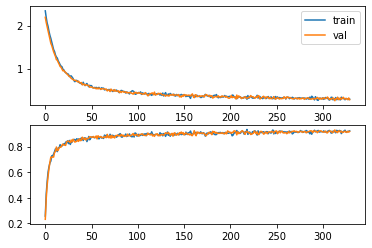

In [16]:
learning_rate = 0.1  
batch_size = 1200
num_epochs = 10
hidden_dim = 1600
# Try Xavier initialization, although need to use same scaling for both layers, so averaging
# https://keras.io/api/layers/initializers/
size_input = x_train.shape[1]
weight_scale1 = numpy.sqrt(2./(size_input+hidden_dim))
weight_scale2 = numpy.sqrt(2./(hidden_dim+nb_classes))
weight_scale = (weight_scale1 + weight_scale2)/2
print(weight_scale)
losses, accuracies, model = training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot)

plt.figure()
plt.subplot(2,1,1)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies[:,0])
plt.plot(accuracies[:,1])